In [23]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import load_model


create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")


import my_functions_product1 as myFC
import matplotlib.pyplot as plt

sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


In [26]:
# reading the file from a path and list the field names and input columns of interest
#path = 'data/adult.data'
#path = 'data/compas.csv'
path = 'data/bank.csv'
X_df, Ybin, Zbin, result_fname = myFC.read_process_data_output_bias(path)

Columns in your data are:
  ['age' 'job' 'marital' 'education' 'default' 'housing' 'loan' 'contact'
 'month' 'day_of_week' 'duration' 'campaign' 'pdays' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'y']
Your possible target columns '{'emp.var.rate', 'euribor3m', 'loan', 'y', 'job', 'default', 'nr.employed', 'duration', 'education', 'pdays', 'day_of_week', 'poutcome', 'cons.price.idx', 'campaign', 'age', 'previous', 'housing', 'contact', 'month', 'cons.conf.idx', 'marital'}'
Which column is your target column?:y
Your target column is 'y'
-----------------------------------

Do you have any column for your current prediction? Please enter Y or N:N
Do you have any column for your current prediction? You entered'N'
-----------------------------------

Your prediction column possible values '{'yes', 'no'}'
Please enter two different labels in the target field: 
Enter label 0:no
Your target label 0 is 'no'
---------------------------------

### Feature Creation

In [27]:
X_train, X_test, y_train, y_test, Z_train, Z_test = myFC.feature_creation(X_df, Ybin, Zbin)

(20594, 52)
(20594, 52)


### Setting up default architectures

In [28]:
n_features = X_train.shape[1]
main_task_arch_json_string, adv_task_arch_json_string = myFC.Default_main_task_adv_architecture(n_features)

## Model and compile only main task: check prediction results

In [29]:
h5_file_name = 'main_task_ori_trained_model.h5'
main_task_accuracy, p_rule_for_Y1, y_pred = myFC.pre_train_main_task(main_task_arch_json_string, h5_file_name,X_train, y_train,X_test,y_test,Z_test)

Accuracy: 91.12


## Combining the main task arch with the adversarial arch
## Train using pre-trained weights of main model

In [30]:
tradeoff_lambda_v = [0,20,40,60,80,100] 
pre_load_flag = True

main_task_trained_weight_file = 'main_task_ori_trained_model.h5'

for tradeoff_lambda in tradeoff_lambda_v:
    print('tradeoff_lambda = ', tradeoff_lambda)
    # initialise FairClassifier
    clf = myFC.FairClassifier(tradeoff_lambda=tradeoff_lambda,
                     main_task_arch_json_string=main_task_arch_json_string,
                     adv_task_arch_json_string=adv_task_arch_json_string,
                     pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    
    # pre-train both adverserial and classifier networks
    clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5,pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred = myFC.bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    # adverserial train on train set and validate on test set
    clf.fit(X_train, y_train, Z_train, 
            validation_data=(X_test, y_test, Z_test),
            T_iter=165, save_figs=create_gif)
    after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred = myFC.bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    
    result_fname_y_pred_before_after,result_fname_acc_p_before_after = myFC.saving_performance_result(before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred, after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred,tradeoff_lambda,result_fname)




tradeoff_lambda =  0
Accuracy: 91.12
Accuracy: 91.10
tradeoff_lambda =  20
Accuracy: 91.12
Accuracy: 89.20
tradeoff_lambda =  40
Accuracy: 91.12
Accuracy: 89.51
tradeoff_lambda =  60
Accuracy: 91.12
Accuracy: 89.17
tradeoff_lambda =  80
Accuracy: 91.12
Accuracy: 89.42
tradeoff_lambda =  100
Accuracy: 91.12
Accuracy: 89.73


# Reading the result files

### Accuracy & p-score trade-off curves

In [31]:
tradeoff_lambda_v = [0,20,40,60,80,100] 

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

for item in range(len(tradeoff_lambda_v)):
    
    tradeoff_lambda = tradeoff_lambda_v[item]
    result_fname_acc_p_before_after = 'acc_p_BA_'+result_fname + 'L'+ str(tradeoff_lambda)+'.txt'
    result_fname_acc_p_before_after = './Trade-off-results/'+result_fname_acc_p_before_after
    Bacc_Bp_Aacc_Ap = np.loadtxt(result_fname_acc_p_before_after, delimiter=',')

    Bacc_Bp_Aacc_Ap_results[item, :] = Bacc_Bp_Aacc_Ap
    


Text(0.5,1,'Trade off')

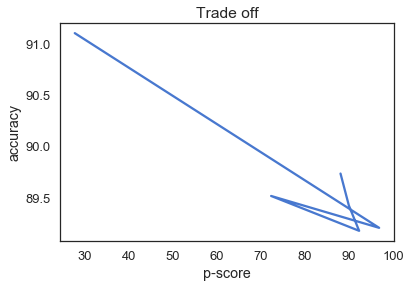

In [32]:
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('p-score')
plt.ylabel('accuracy')
plt.title('Trade off')

### y_pred distribution curves

In [33]:
result_fname_y_pred_before_after = 'y_pred_'+result_fname +'L' + str(tradeoff_lambda) +'.txt'
result_fname_y_pred_before_after = './Trade-off-results/'+ result_fname_y_pred_before_after

BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

#### Before the de-biaser

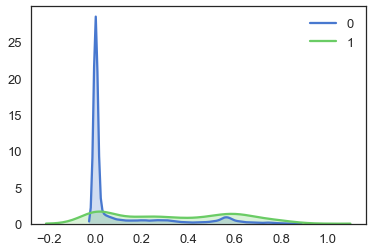

In [34]:
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))

#### After the de-biaser

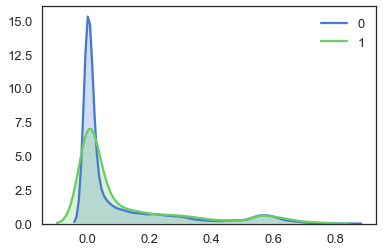

In [35]:
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))